In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize


nltk.download('stopwords', quiet=True)
stopwords = stopwords.words('english')
sns.set(style="white", font_scale=1.2)
plt.rcParams["figure.figsize"] = [10,8]
pd.set_option.display_max_columns = 0
pd.set_option.display_max_rows = 0

In [2]:
import os

file_path = "kaggle_data/nlp-getting-started/"
for dirname, _, filenames in os.walk(file_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


kaggle_data/nlp-getting-started/sample_submission.csv
kaggle_data/nlp-getting-started/test.csv
kaggle_data/nlp-getting-started/train.csv


In [3]:
train = pd.read_csv(file_path+"train.csv")
test = pd.read_csv(file_path+"test.csv")
sample = pd.read_csv(file_path+"sample_submission.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
id          3263 non-null int64
keyword     3237 non-null object
location    2158 non-null object
text        3263 non-null object
dtypes: int64(1), object(3)
memory usage: 102.0+ KB


In [10]:
pd.unique(train['target'])

array([1, 0], dtype=int64)

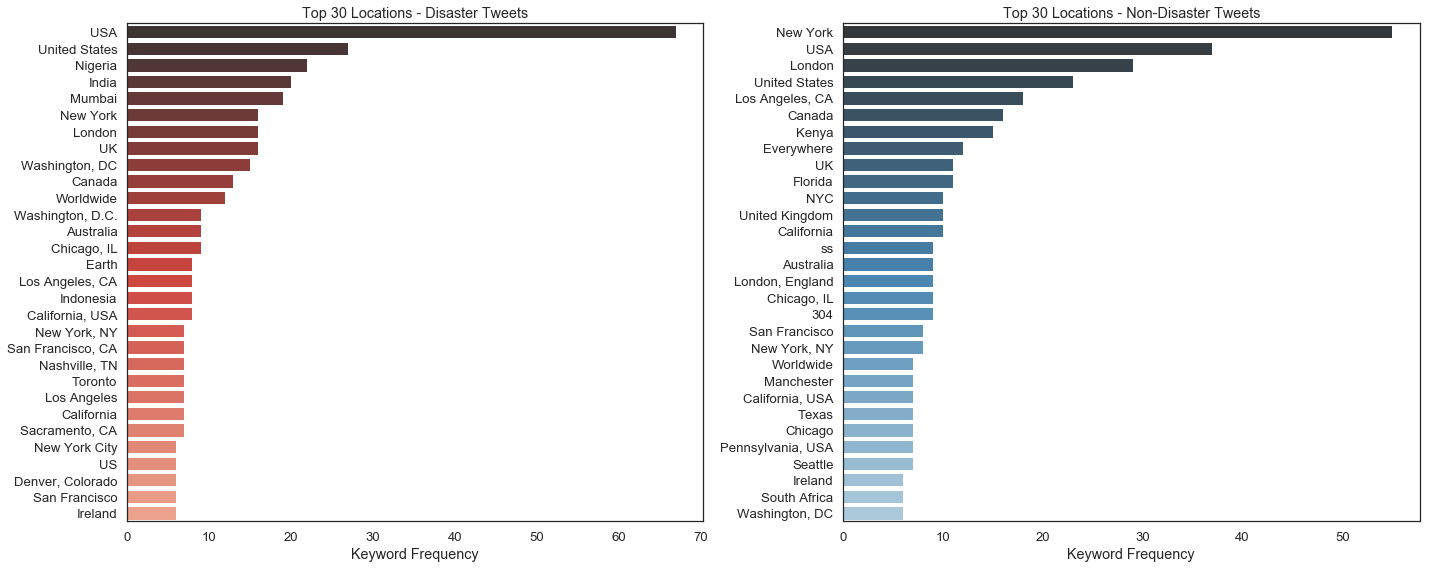

In [11]:
disaster_locations = train.loc[train["target"] == 1]["location"].value_counts()
nondisaster_locations = train.loc[train["target"] == 0]["location"].value_counts()

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=disaster_locations[0:30].index, x=disaster_locations[0:30], orient='h', ax=ax[0], palette="Reds_d")
sns.barplot(y=nondisaster_locations[0:30].index, x=nondisaster_locations[0:30], orient='h', ax=ax[1], palette="Blues_d")
ax[0].set_title("Top 30 Locations - Disaster Tweets")
ax[0].set_xlabel("Keyword Frequency")
ax[1].set_title("Top 30 Locations - Non-Disaster Tweets")
ax[1].set_xlabel("Keyword Frequency")
plt.tight_layout()
plt.show()

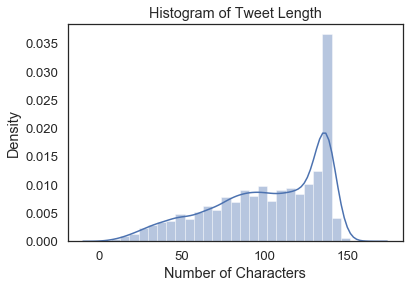

In [12]:
train["tweet_length"] = train["text"].apply(len)
sns.distplot(train["tweet_length"])
plt.title("Histogram of Tweet Length")
plt.xlabel("Number of Characters")
plt.ylabel("Density")
plt.show()

In [13]:
min(train["tweet_length"]), max(train["tweet_length"])

(7, 157)

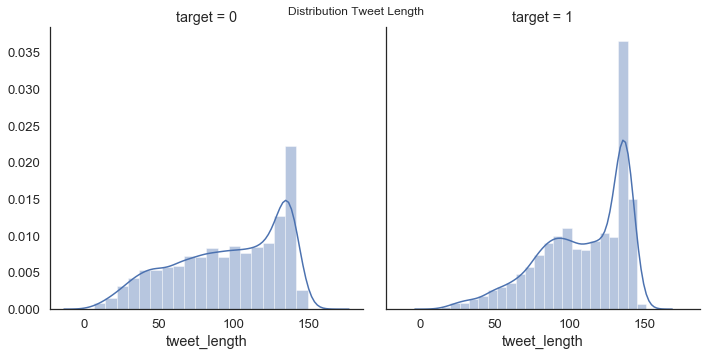

In [14]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "tweet_length")
plt.suptitle("Distribution Tweet Length")
plt.show()

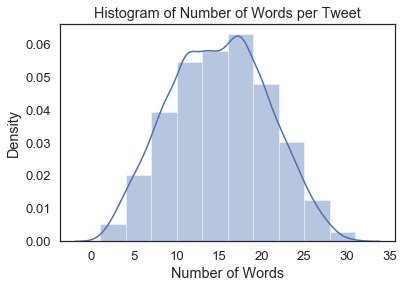

In [15]:
def count_words(x):
    return len(x.split())

train["num_words"] = train["text"].apply(count_words)
sns.distplot(train["num_words"], bins=10)
plt.title("Histogram of Number of Words per Tweet")
plt.xlabel("Number of Words")
plt.ylabel("Density")
plt.show()

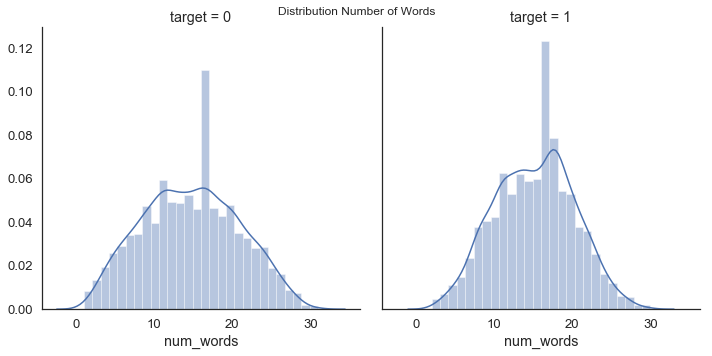

In [16]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "num_words")
plt.suptitle("Distribution Number of Words")
plt.show()

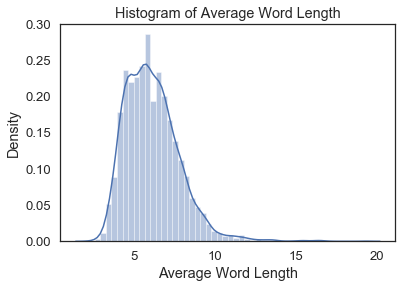

In [17]:
def avg_word_length(x):
    return np.sum([len(w) for w in x.split()]) / len(x.split())

train["avg_word_length"] = train["text"].apply(avg_word_length)
sns.distplot(train["avg_word_length"])
plt.title("Histogram of Average Word Length")
plt.xlabel("Average Word Length")
plt.ylabel("Density")
plt.show()

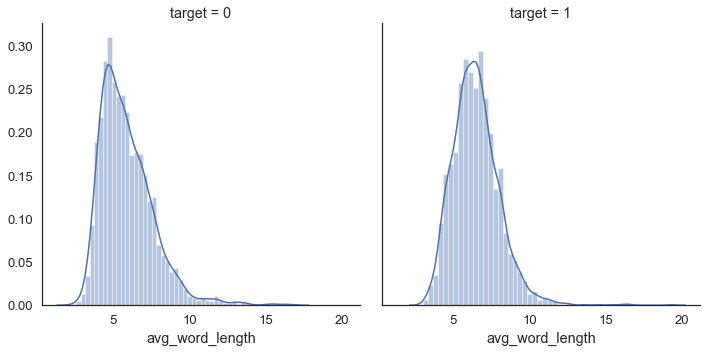

In [18]:
g = sns.FacetGrid(train, col="target", height=5)
g = g.map(sns.distplot, "avg_word_length")

In [21]:
from collections import defaultdict, Counter

def create_corpus(target):
    corpus = []

    for w in train.loc[train["target"] == target]["text"].str.split():
        for i in w:
            corpus.append(i)
            
    return corpus

def create_corpus_dict(target):
    corpus = create_corpus(target)
            
    stop_dict = defaultdict(int)
    for word in corpus:
        if word in stopwords:
            stop_dict[word] += 1
    return sorted(stop_dict.items(), key=lambda x:x[1], reverse=True)

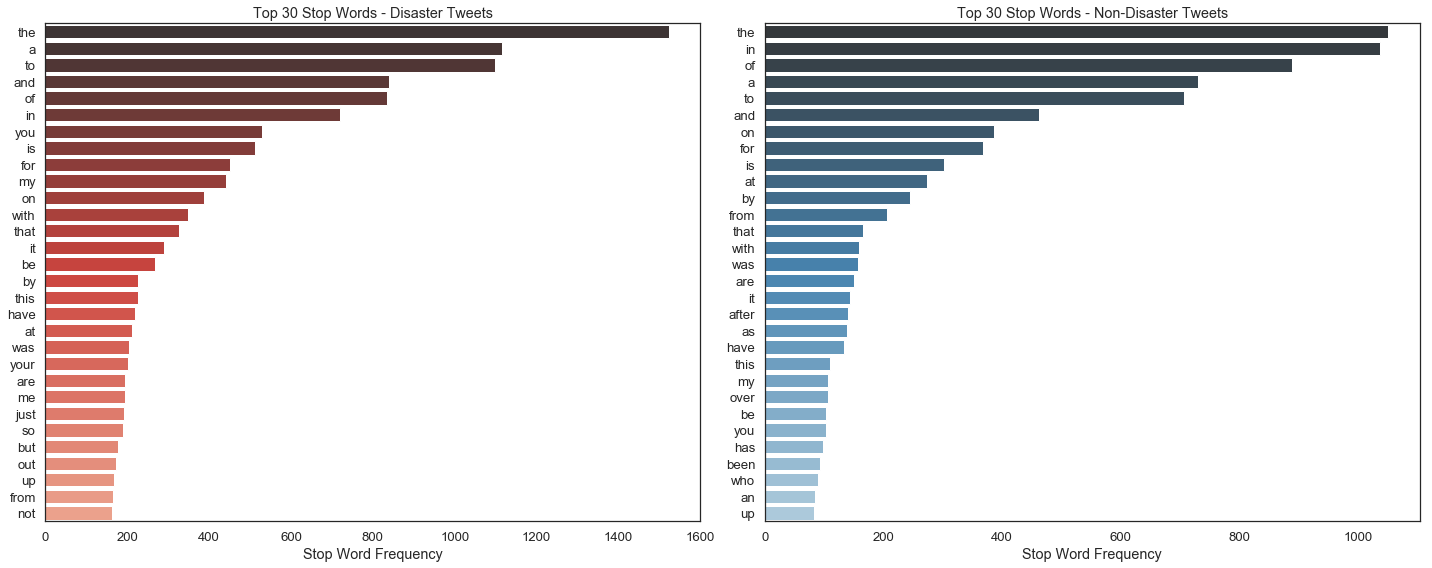

In [22]:
corpus_disaster_dict = create_corpus_dict(0)
corpus_non_disaster_dict = create_corpus_dict(1)

disaster_x, disaster_y = zip(*corpus_disaster_dict)
non_disaster_x, non_disaster_y = zip(*corpus_non_disaster_dict)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(y=list(disaster_x)[0:30], x=list(disaster_y)[0:30], orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(y=list(non_disaster_x)[0:30], x=list(non_disaster_y)[0:30], orient='h', palette="Blues_d", ax=ax[1]) 
ax[0].set_title("Top 30 Stop Words - Disaster Tweets")
ax[0].set_xlabel("Stop Word Frequency")
ax[1].set_title("Top 30 Stop Words - Non-Disaster Tweets")
ax[1].set_xlabel("Stop Word Frequency")
plt.tight_layout()
plt.show()

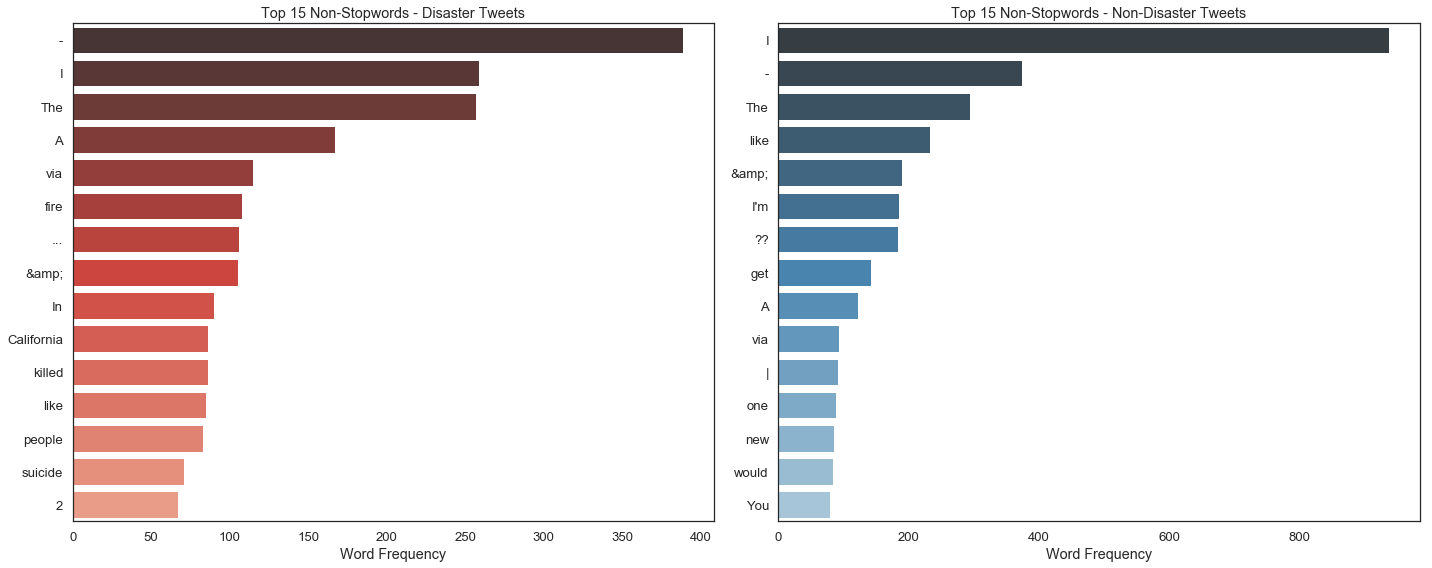

In [23]:
corpus_disaster, corpus_non_disaster = create_corpus(1), create_corpus(0)
counter_disaster, counter_non_disaster = Counter(corpus_disaster), Counter(corpus_non_disaster)
x_disaster, y_disaster, x_non_disaster, y_non_disaster = [], [], [], []

counter = 0
for word, count in counter_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_disaster.append(word)
        y_disaster.append(count)

counter = 0
for word, count in counter_non_disaster.most_common()[0:100]:
    if (word not in stopwords and counter < 15):
        counter += 1
        x_non_disaster.append(word)
        y_non_disaster.append(count)

fig, ax = plt.subplots(1,2, figsize=(20,8))
sns.barplot(x=y_disaster, y=x_disaster, orient='h', palette="Reds_d", ax=ax[0])
sns.barplot(x=y_non_disaster, y=x_non_disaster, orient='h', palette="Blues_d", ax=ax[1])
ax[0].set_title("Top 15 Non-Stopwords - Disaster Tweets")
ax[0].set_xlabel("Word Frequency")
ax[1].set_title("Top 15 Non-Stopwords - Non-Disaster Tweets")
ax[1].set_xlabel("Word Frequency")
plt.tight_layout()
plt.show()

Not Disaster: 57.03%, Disaster: 42.97%


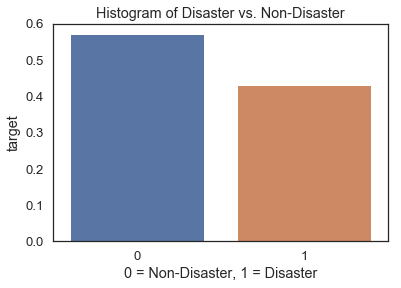

In [24]:
target_vc = train["target"].value_counts(normalize=True)
print("Not Disaster: {:.2%}, Disaster: {:.2%}".format(target_vc[0], target_vc[1]))
sns.barplot(x=target_vc.index, y=target_vc)
plt.title("Histogram of Disaster vs. Non-Disaster")
plt.xlabel("0 = Non-Disaster, 1 = Disaster")
plt.show()

In [25]:
train.head()

,id,keyword,location,text,target,tweet_length,num_words,avg_word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000


In [28]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt

# remove '#' handle
train['tweet'] = np.vectorize(remove_pattern)(train['text'], "#[\w]*")
test['tweet'] = np.vectorize(remove_pattern)(test['text'], "#[\w]*") 
train.head()

#Delete everything except alphabet
train['tweet'] = train['tweet'].str.replace("[^a-zA-Z#]", " ")
test['tweet'] = test['tweet'].str.replace("[^a-zA-Z#]", " ")
train.head()


#Dropping words whose length is less than 3
train['tweet'] = train['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
test['tweet'] = test['tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
train.head()


#convert all the words into lower case
train['tweet'] = train['tweet'].str.lower()
test['tweet'] = test['tweet'].str.lower()


# tokens of words  
train['tokenized_sents'] = train.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)
test['tokenized_sents'] = test.apply(lambda row: nltk.word_tokenize(row['tweet']), axis=1)

#function to remove stop words
def remove_stops(row):
    my_list = row['tokenized_sents']
    meaningful_words = [w for w in my_list if not w in stopwords]
    return (meaningful_words)

#removing stop words
train['clean_tweet'] = train.apply(remove_stops, axis=1)
test['clean_tweet'] = test.apply(remove_stops, axis=1)
train.drop(["tweet","tokenized_sents"], axis = 1, inplace = True)
test.drop(["tweet","tokenized_sents"], axis = 1, inplace = True)

#re-join the words after tokenization
def rejoin_words(row):
    my_list = row['clean_tweet']
    joined_words = ( " ".join(my_list))
    return joined_words

train['clean_tweet'] = train.apply(rejoin_words, axis=1)
test['clean_tweet'] = test.apply(rejoin_words, axis=1)
train.head()

,id,keyword,location,text,target,tweet_length,num_words,avg_word_length,clean_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,13,4.384615,deeds reason allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,7,4.571429,forest fire near ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,22,5.090909,residents asked shelter place notified officer...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,8,7.125000,people receive evacuation orders california
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,16,4.500000,sent photo ruby smoke pours school


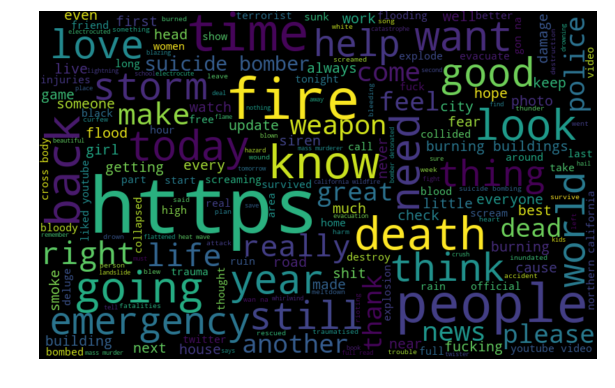

In [29]:
all_word = ' '.join([text for text in train['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

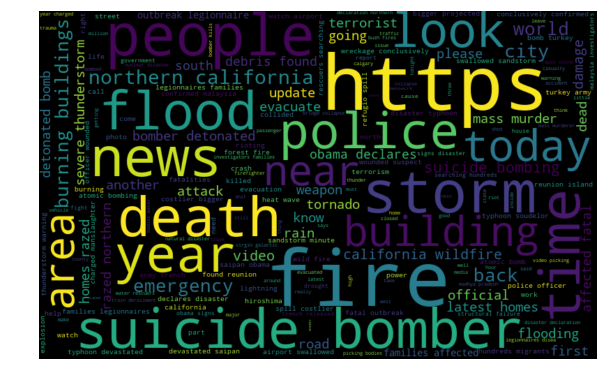

In [30]:
normal_words =' '.join([text for text in train['clean_tweet'][train['target'] == 1]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

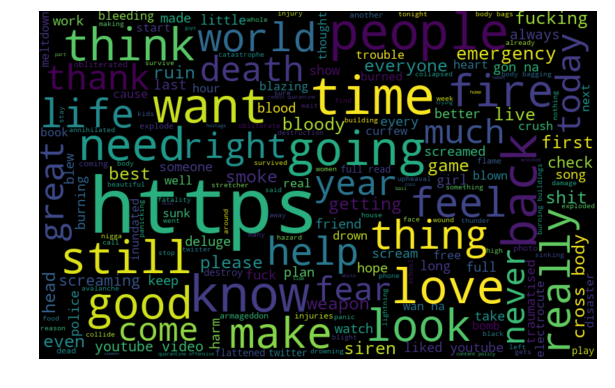

In [31]:
normal_words =' '.join([text for text in train['clean_tweet'][train['target'] == 0]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [32]:
my_learning_rate = 3E-6 # default is 5E-5
my_adam_epsilon = 1E-8 # default is 1E-8
my_number_of_epochs = 15
my_warmup = 3
my_mini_batch_size = 32

In [33]:
import torch

if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('I will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [34]:
train = pd.read_csv(file_path+"train.csv")
test = pd.read_csv(file_path+"test.csv")
sample = pd.read_csv(file_path+"sample_submission.csv")

In [35]:
def preprocess(text):

    text=text.lower()
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'http?:\/\/.*[\r\n]*', '', text)
    #Replace &amp, &lt, &gt with &,<,> respectively
    text=text.replace(r'&amp;?',r'and')
    text=text.replace(r'&lt;',r'<')
    text=text.replace(r'&gt;',r'>')
    #remove hashtag sign
    #text=re.sub(r"#","",text)   
    #remove mentions
    text = re.sub(r"(?:\@)\w+", '', text)
    #text=re.sub(r"@","",text)
    #remove non ascii chars
    text=text.encode("ascii",errors="ignore").decode()
    #remove some puncts (except . ! ?)
    text=re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~]+','',text)
    text=re.sub(r'[!]+','!',text)
    text=re.sub(r'[?]+','?',text)
    text=re.sub(r'[.]+','.',text)
    text=re.sub(r"'","",text)
    text=re.sub(r"\(","",text)
    text=re.sub(r"\)","",text)
    
    text=" ".join(text.split())
    return text

train['text'] = train['text'].apply(preprocess)
test['text'] = test['text'].apply(preprocess)
train = train[train["text"]!='']

train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,13000 people receive wildfires evacuation orde...,1
4,7,NaN,NaN,just got sent this photo from ruby alaska as s...,1


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7561 entries, 0 to 7612
Data columns (total 5 columns):
id          7561 non-null int64
keyword     7500 non-null object
location    5047 non-null object
text        7561 non-null object
target      7561 non-null int64
dtypes: int64(2), object(3)
memory usage: 354.4+ KB


In [37]:
train['target'].value_counts()

0    4314
1    3247
Name: target, dtype: int64

In [38]:
# Get the lists of texts and labels.
texts = train.text.values
labels = train.target.values

#take a look at the first 50 training examples
for n in range(50):
    print(texts[n], "(LABEL:", labels[n], ")")

our deeds are the reason of this earthquake may allah forgive us all (LABEL: 1 )
forest fire near la ronge sask canada (LABEL: 1 )
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected (LABEL: 1 )
13000 people receive wildfires evacuation orders in california (LABEL: 1 )
just got sent this photo from ruby alaska as smoke from wildfires pours into a school (LABEL: 1 )
rockyfire update california hwy 20 closed in both directions due to lake county fire cafire wildfires (LABEL: 1 )
flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas (LABEL: 1 )
im on top of the hill and i can see a fire in the woods (LABEL: 1 )
theres an emergency evacuation happening now in the building across the street (LABEL: 1 )
im afraid that the tornado is coming to our area (LABEL: 1 )
three people died from the heat wave so far (LABEL: 1 )
haha south tampa is getting flooded hah wait a second i li